In [1]:
# !pip install webknossos

%load_ext autoreload
%autoreload 2

In [2]:
import webknossos as wk


In [3]:
import sys, os
sys.path.append(os.getcwd())

import utils

In [5]:
my_api_token="pU8v4Mz7qgGF0FEgQefswA"
my_url = "https://webknossos.org"
organization_id = "8632814cfac2f959"

#
# datasets = ["121_lim60_tomo10a_16bit",
#             "121_lim30_tomo10a_16bit",
#             "21_lim30_tomo10a_16bit",
#             "21_lim60_tomo10a_16bit",
#             ]

datasets = [
    "21_lim10_tomo10a_16bit",
    "21_lim20_tomo10a_16bit",
    "21_lim30_tomo10a_16bit",
    "21_lim40_tomo10a_16bit",
    "21_lim50_tomo10a_16bit",           
    "21_lim60_tomo10a_16bit",
]

In [6]:
with wk.webknossos_context(url=my_url, token=my_api_token):
    annotation_id = 'https://webknossos.org/annotations/683f3db8010000d907dc85a5#1620,701,16,0,0.062,30' #'https://webknossos.org/annotations/680ba75a0100008401cd75bd#1034,1034,95,0,2,21'
    annotation = wk.Annotation.download(annotation_id)

    print(f"Downloaded annotation: {annotation.name}")


Downloaded annotation: 121_lim60_tomo10a_16bit_beads_ATK


In [6]:

i_dataset = 0
dataset_name = datasets[i_dataset]
print(f"Dataset: {dataset_name}")


with wk.webknossos_context(url=my_url, token=my_api_token):

    dataset = wk.Dataset.open_remote(dataset_name, organization_id=organization_id)
    print(f"Opened dataset: {dataset.name}")


Dataset: 121_lim60_tomo10a_16bit
Opened dataset: 121_lim60_tomo10a_16bit


In [ ]:
annotation_points = utils.get_annotation_points(annotation)
bounding_boxes = utils.compute_bounding_boxes(annotation_points, box_size=32)

subvolumes = utils.download_subvolumes_individually(
    dataset_name=dataset_name,
    bounding_boxes=bounding_boxes,
    api_token=my_api_token,
    organization_id=organization_id,
    webknossos_url=my_url
)


## Download data before first use

In [ ]:
for i_dataset in range(len(datasets)):
    dataset_name = datasets[i_dataset]
    print(f"Dataset: {dataset_name}")

    with wk.webknossos_context(url=my_url, token=my_api_token):
        dataset = wk.Dataset.open_remote(dataset_name, organization_id=organization_id)
        print(f"Opened dataset: {dataset.name}")

    annotation_points = utils.get_annotation_points(annotation)
    bounding_boxes = utils.compute_bounding_boxes(annotation_points, box_size=32)

    subvolumes = utils.download_subvolumes_individually(
        dataset_name=dataset_name,
        bounding_boxes=bounding_boxes,
        api_token=my_api_token,
        organization_id=organization_id,
        webknossos_url=my_url
    )

    # Save after download
    file_name = f"{dataset_name}.npz"
    utils.save_subvolumes_to_npz(subvolumes, annotation_points, file_name)


### optionally inspect a few

In [ ]:
# utils.plot_bead_triplet_montage(subvolumes) #, title="Center Slices of Each Bead (Z, Y, X)")


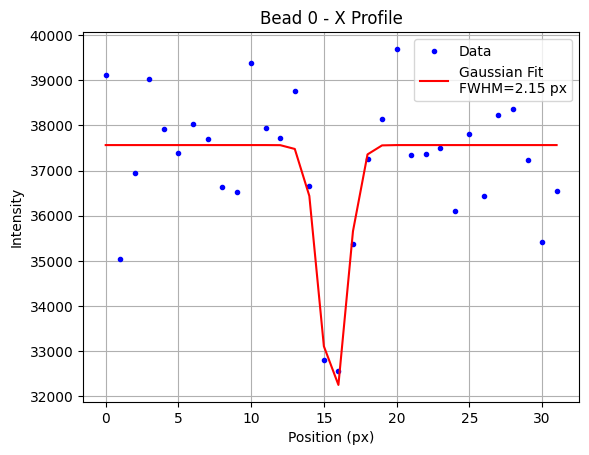

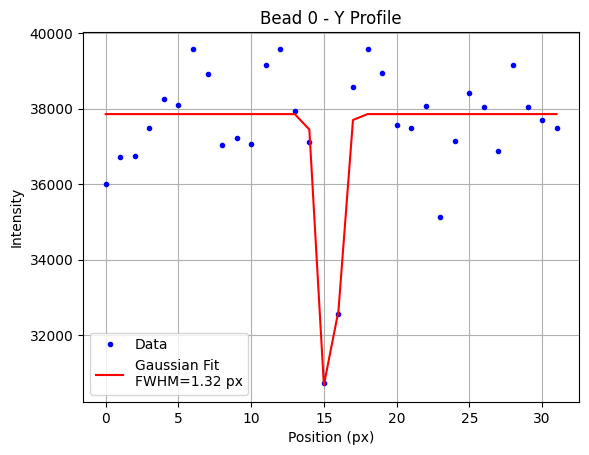

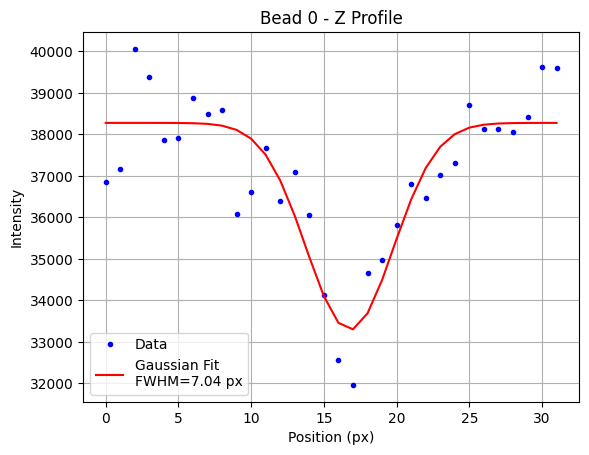

(np.float64(7.041866183844441),
 array([-4.98471457e+03,  1.67822800e+01,  2.99017672e+00,  3.82763352e+04]))

In [8]:
# Pick a subvolume
vol = subvolumes[5]
z, y, x = vol.shape

profile_z = vol[:, y//2, x//2]
profile_y = vol[z//2, :, x//2]
profile_x = vol[z//2, y//2, :]

# Fit and plot
utils.fit_gaussian_and_compute_fwhm(profile_x, plot_fit=True, title="Bead 0 - X Profile")
utils.fit_gaussian_and_compute_fwhm(profile_y, plot_fit=True, title="Bead 0 - Y Profile")
utils.fit_gaussian_and_compute_fwhm(profile_z, plot_fit=True, title="Bead 0 - Z Profile")


## Now load the pre-downloaded data

In [9]:
subvolumes_list = []

all_fwhms_x = []
all_fwhms_y = []
all_fwhms_z = []

for i_dataset, dataset_name in enumerate(datasets):
    print(f"Processing dataset {i_dataset}: {dataset_name}")
    file_name = f"{dataset_name}.npz"
    subvolumes, annotation_points = utils.load_subvolumes_from_npz(file_name)
    subvolumes_list.append(subvolumes)
    fwhms_x, fwhms_y, fwhms_z = utils.compute_fwhms_from_subvolumes(subvolumes)

    all_fwhms_x.append(fwhms_x)
    all_fwhms_y.append(fwhms_y)
    all_fwhms_z.append(fwhms_z)


Processing dataset 0: 21_lim10_tomo10a_16bit
Processing dataset 1: 21_lim20_tomo10a_16bit
Processing dataset 2: 21_lim30_tomo10a_16bit
Processing dataset 3: 21_lim40_tomo10a_16bit
Processing dataset 4: 21_lim50_tomo10a_16bit


/Users/xiu/Library/CloudStorage/OneDrive-YaleUniversity/code/AKlab/tem-tomo/bead_resolution/utils.py:205: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(gaussian, x, profile, p0=p0)


Processing dataset 5: 21_lim60_tomo10a_16bit


In [10]:
out_x, out_y, out_z = utils.report_fwhm_outliers(all_fwhms_x, all_fwhms_y, all_fwhms_z)


X-axis: mean=2.77, std=3.46, outliers=3
Y-axis: mean=60.88, std=344.68, outliers=4
Z-axis: mean=53.95, std=305.00, outliers=4


In [ ]:
    
# utils.plot_fwhm_outliers(subvolumes_list, all_fwhms_x, 'X', out_x)
# utils.plot_fwhm_outliers(subvolumes_list, all_fwhms_y, 'Y', out_y)
# utils.plot_fwhm_outliers(subvolumes_list, all_fwhms_z, 'Z', out_z)

In [ ]:
# utils.plot_fwhm_outliers_image(subvolumes_list, out_x, axis_label='X')
# utils.plot_fwhm_outliers_image(subvolumes_list, out_y, axis_label='Y')
# utils.plot_fwhm_outliers_image(subvolumes_list, out_z, axis_label='Z')

In [11]:
# Filter in-place: remove FWHM values > 100 from each sublist
all_fwhms_x = [[val for val in sublist if val <= 100] for sublist in all_fwhms_x]
all_fwhms_y = [[val for val in sublist if val <= 100] for sublist in all_fwhms_y]
all_fwhms_z = [[val for val in sublist if val <= 100] for sublist in all_fwhms_z]


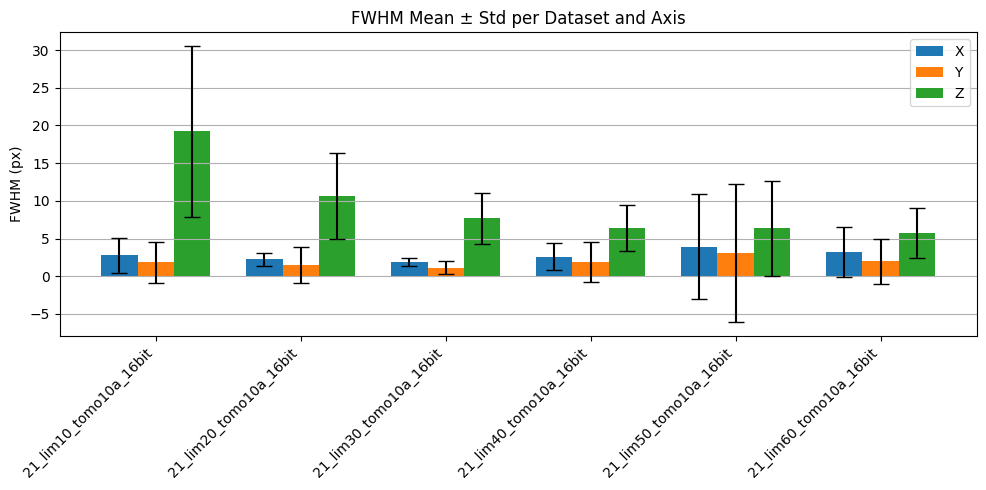

In [12]:
utils.plot_fwhm_summary_by_dataset(all_fwhms_x, all_fwhms_y, all_fwhms_z, dataset_names=datasets)


In [13]:
clean_fwhms_x, clean_fwhms_y, clean_fwhms_z = utils.remove_joint_outliers(
    all_fwhms_x, all_fwhms_y, all_fwhms_z, threshold=100.0
)

In [14]:
# Filter datasets and fwhm lists together to drop empty cases
filtered = [
    (name, fx, fy, fz)
    for name, fx, fy, fz in zip(datasets, all_fwhms_x, all_fwhms_y, all_fwhms_z)
    if len(fx) > 0 and len(fy) > 0 and len(fz) > 0
]

# Unpack filtered lists
datasets, all_fwhms_x, all_fwhms_y, all_fwhms_z = zip(*filtered)


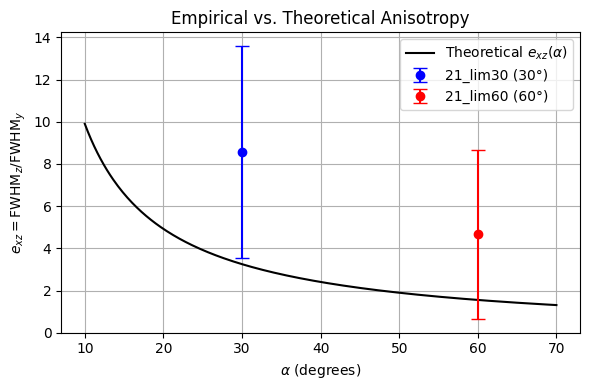

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import math

# --- Theoretical Rademacher function ---
def calculate_e_xz(alpha_deg):
    alpha_rad = math.radians(alpha_deg)
    num = alpha_rad + math.sin(alpha_rad) * math.cos(alpha_rad)
    den = alpha_rad - math.sin(alpha_rad) * math.cos(alpha_rad)
    if den == 0:
        return np.nan
    return math.sqrt(num / den)

# --- Get theoretical curve ---
alphas = np.linspace(10, 70, 300)
e_xz_theory = [calculate_e_xz(a) for a in alphas]

# --- Find indices for the two datasets ---
i_30 = [i for i, name in enumerate(datasets) if '21_lim30' in name][0]
i_60 = [i for i, name in enumerate(datasets) if '21_lim60' in name][0]

# --- Compute empirical e_xz = FWHM_z / FWHM_y per dataset ---
def empirical_ratio_and_std(fwhms_z, fwhms_y, clip_max=100.0):
    """
    Compute mean/std of FWHM_z / FWHM_y while filtering bad values:
    - removes NaNs
    - removes zero or near-zero denominators
    - clips extreme FWHMs above `clip_max`
    """
    z = np.array(fwhms_z)
    y = np.array(fwhms_y)

    # Clean both numerator and denominator
    valid_mask = (
        ~np.isnan(z) & ~np.isnan(y) &
        (y > 0.1) & (z < clip_max) & (y < clip_max)
    )
    z_clean = z[valid_mask]
    y_clean = y[valid_mask]

    if len(z_clean) == 0:
        return np.nan, np.nan

    ratios = z_clean / y_clean
    return np.nanmean(ratios), np.nanstd(ratios)


e_30_mean, e_30_std = empirical_ratio_and_std(clean_fwhms_z[i_30], clean_fwhms_y[i_30])
e_60_mean, e_60_std = empirical_ratio_and_std(clean_fwhms_z[i_60], clean_fwhms_y[i_60])

# --- Plot ---
plt.figure(figsize=(6, 4))
plt.plot(alphas, e_xz_theory, label=r'Theoretical $e_{xz}(\alpha)$', color='black')

# Overlay empirical points with error bars
plt.errorbar(30, e_30_mean, yerr=e_30_std, fmt='o', capsize=5, label='21_lim30 (30°)', color='blue')
plt.errorbar(60, e_60_mean, yerr=e_60_std, fmt='o', capsize=5, label='21_lim60 (60°)', color='red')

plt.xlabel(r'$\alpha$ (degrees)')
plt.ylabel(r'$e_{xz} = \mathrm{FWHM}_z / \mathrm{FWHM}_y$')
plt.title('Empirical vs. Theoretical Anisotropy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.legend(loc='upper right')
plt.show()


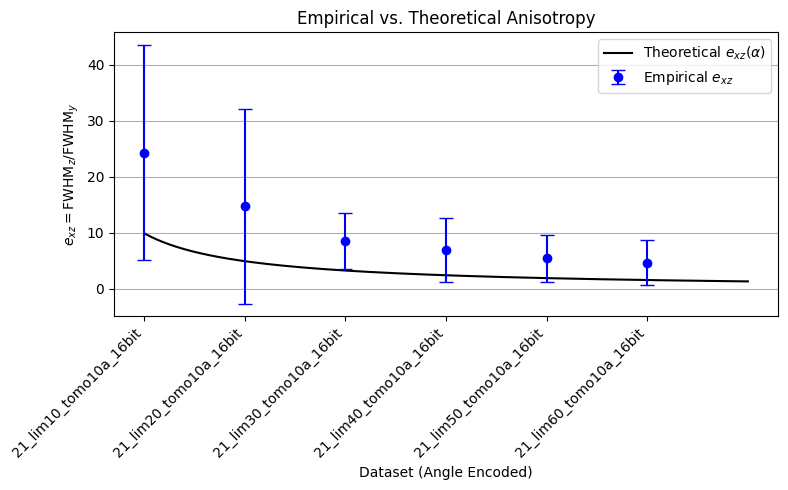

In [17]:
import re
import numpy as np
import matplotlib.pyplot as plt

# Extract angles from dataset names
def extract_angle(name):
    match = re.search(r'lim(\d+)', name)
    return int(match.group(1)) if match else None

angles = [extract_angle(name) for name in datasets]
dataset_labels = datasets

# Compute empirical e_xz for each dataset
e_means = []
e_stds = []

for name in datasets:
    idx = datasets.index(name)
    mean, std = empirical_ratio_and_std(clean_fwhms_z[idx], clean_fwhms_y[idx])
    e_means.append(mean)
    e_stds.append(std)

# Theoretical curve
alpha_curve = np.linspace(10, 70, 300)
e_theory = [calculate_e_xz(a) for a in alpha_curve]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(alpha_curve, e_theory, label='Theoretical $e_{xz}(\\alpha)$', color='black')

# Empirical data
plt.errorbar(
    angles, e_means, yerr=e_stds, fmt='o', capsize=5, markersize=6,
    label='Empirical $e_{xz}$', color='blue'
)

# X-axis with dataset labels at angle ticks
plt.xticks(angles, dataset_labels, rotation=45, ha='right')
plt.xlabel('Dataset (Angle Encoded)')
plt.ylabel(r'$e_{xz} = \mathrm{FWHM}_z / \mathrm{FWHM}_y$')
plt.title('Empirical vs. Theoretical Anisotropy')
plt.legend(loc='upper right')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


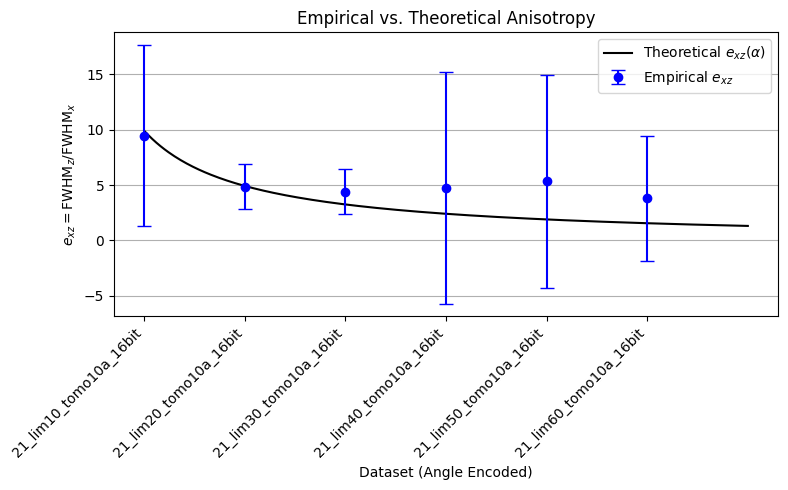

In [19]:
import re
import numpy as np
import matplotlib.pyplot as plt

# Extract angles from dataset names
def extract_angle(name):
    match = re.search(r'lim(\d+)', name)
    return int(match.group(1)) if match else None

angles = [extract_angle(name) for name in datasets]
dataset_labels = datasets

# Compute empirical e_xz for each dataset USING X not Y
e_means = []
e_stds = []

for name in datasets:
    idx = datasets.index(name)
    mean, std = empirical_ratio_and_std(clean_fwhms_z[idx], clean_fwhms_x[idx])
    e_means.append(mean)
    e_stds.append(std)

# Theoretical curve
alpha_curve = np.linspace(10, 70, 300)
e_theory = [calculate_e_xz(a) for a in alpha_curve]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(alpha_curve, e_theory, label='Theoretical $e_{xz}(\\alpha)$', color='black')

# Empirical data
plt.errorbar(
    angles, e_means, yerr=e_stds, fmt='o', capsize=5, markersize=6,
    label='Empirical $e_{xz}$', color='blue'
)

# X-axis with dataset labels at angle ticks
plt.xticks(angles, dataset_labels, rotation=45, ha='right')
plt.xlabel('Dataset (Angle Encoded)')
plt.ylabel(r'$e_{xz} = \mathrm{FWHM}_z / \mathrm{FWHM}_x$')
plt.title('Empirical vs. Theoretical Anisotropy')
plt.legend(loc='upper right')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


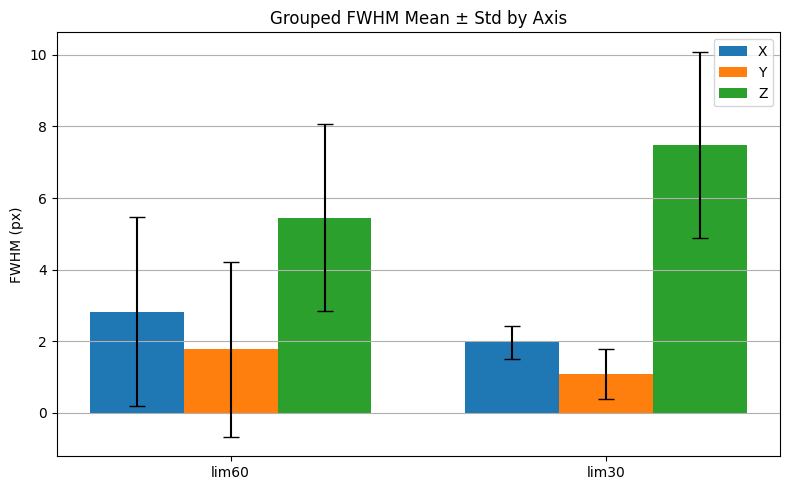

In [ ]:
# group_labels = {
#     'lim60': ['lim60'],
#     'lim30': ['lim30']
# }

# utils.plot_fwhm_summary(
#     all_fwhms_x, all_fwhms_y, all_fwhms_z,
#     dataset_names=datasets,
#     group_labels=group_labels
# )


In [ ]:
fwhms_z = []
fwhms_y = []
fwhms_x = []

for i, vol in enumerate(subvolumes):
    z, y, x = vol.shape

    profile_z = vol[:, y//2, x//2]
    profile_y = vol[z//2, :, x//2]
    profile_x = vol[z//2, y//2, :]

    fwhm_z, _ = utils.fit_gaussian_and_compute_fwhm(profile_z)
    fwhm_y, _ = utils.fit_gaussian_and_compute_fwhm(profile_y)
    fwhm_x, _ = utils.fit_gaussian_and_compute_fwhm(profile_x)

    fwhms_z.append(fwhm_z)
    fwhms_y.append(fwhm_y)
    fwhms_x.append(fwhm_x)


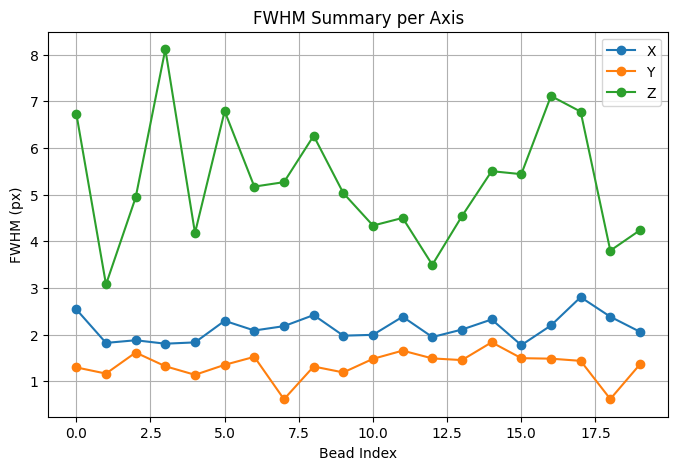

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(fwhms_x, 'o-', label='X')
plt.plot(fwhms_y, 'o-', label='Y')
plt.plot(fwhms_z, 'o-', label='Z')
plt.xlabel('Bead Index')
plt.ylabel('FWHM (px)')
plt.title('FWHM Summary per Axis')
plt.grid(True)
plt.legend()
plt.show()
